## Installation

First, ensure you have the required libraries installed:

In [43]:
!pip install mlcroissant numpy pandas torch matplotlib

## Import Libraries

In [44]:
import mlcroissant as mlc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader

## Part 1: Loading the Full Images Dataset

The full images dataset contains:
- Complete 4-channel image tensors (science, reference, difference, score)
- Candidate coordinates (x, y)
- Photometry features (flux, magnitude, sharpness, roundness, etc.)
- Binary labels (0=bogus, 1=real)

### Loading with Croissant

In [45]:
# Path to your full images dataset
full_images_dataset_dir = "./croissant_full_images/hackathon_dataset"
full_images_croissant_path = f"{full_images_dataset_dir}/croissant.json"

# Load the dataset using Croissant
full_images_dataset = mlc.Dataset(jsonld=full_images_croissant_path)

# Get records iterator
records = full_images_dataset.records("transient_candidates")

# Load first record as example
first_record = next(iter(records))
print("Available fields in full images dataset:")
for key in first_record.keys():
    print(f"  - {key}")

  -  [Metadata(roman_croissant_full_images)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/version" is recommended, but does not exist.


Available fields in full images dataset:
  - transient_candidates/id
  - transient_candidates/x
  - transient_candidates/y
  - transient_candidates/sharpness
  - transient_candidates/roundness1
  - transient_candidates/roundness2
  - transient_candidates/npix
  - transient_candidates/peak
  - transient_candidates/flux
  - transient_candidates/mag
  - transient_candidates/daofind_mag
  - transient_candidates/flags
  - transient_candidates/match
  - transient_candidates/label
  - transient_candidates/jid
  - transient_candidates/image_path


### Inspecting Full Image Data

In [46]:
# Load a full image tensor
rel_path = first_record['transient_candidates/image_path']
if isinstance(rel_path, bytes):
    rel_path = rel_path.decode('utf-8')
image_path = Path(full_images_dataset_dir) / rel_path
full_image = np.load(image_path)

print(f"Image shape: {full_image.shape}")
print(f"Image dtype: {full_image.dtype}")
print(f"Candidate position: ({first_record['transient_candidates/x']:.1f}, {first_record['transient_candidates/y']:.1f})")
print(f"Label: {first_record['transient_candidates/label']} ({'Real' if first_record['transient_candidates/label'] == 1 else 'Bogus'})")
print(f"Flux: {first_record['transient_candidates/flux']:.2f}")
print(f"Magnitude: {first_record['transient_candidates/mag']:.2f}")

Image shape: (4089, 4089, 4)
Image dtype: float32
Candidate position: (2391.4, 0.4)
Label: 0 (Bogus)
Flux: 2.26
Magnitude: -0.89


### Visualizing Full Image Channels

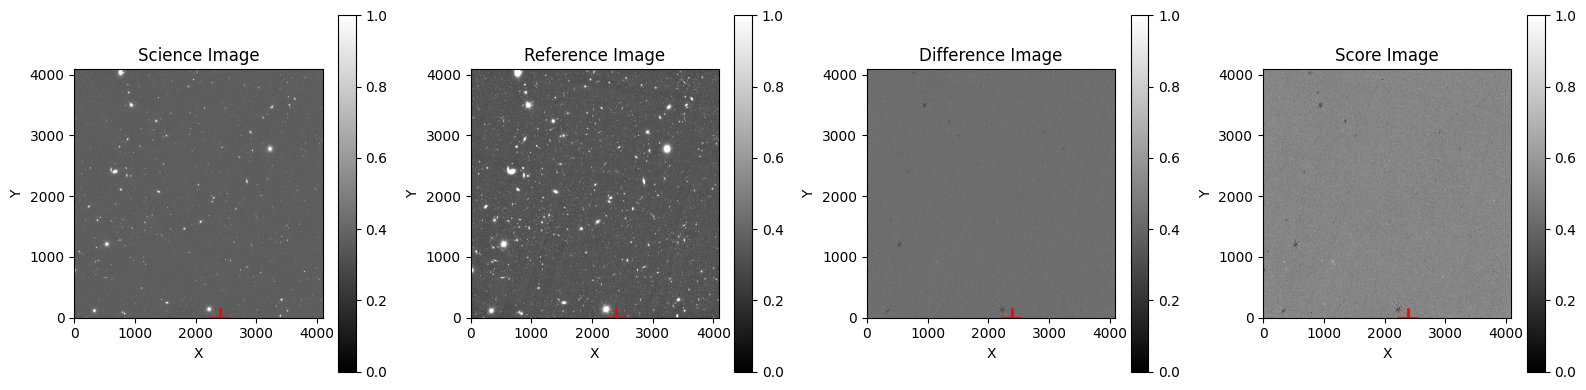

In [47]:
# Visualize the 4 channels
channel_names = ['Science', 'Reference', 'Difference', 'Score']

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (ax, name) in enumerate(zip(axes, channel_names)):
    im = ax.imshow(full_image[:, :, i], cmap='gray', origin='lower')
    ax.set_title(f"{name} Image")
    ax.plot(first_record['transient_candidates/x'], first_record['transient_candidates/y'], 'r+', markersize=15, markeredgewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

### Creating a PyTorch Dataset for Full Images

In [48]:
class FullImagesDataset(Dataset):
    """PyTorch dataset for full images with runtime cutout extraction."""
    
    def __init__(self, croissant_path, cutout_size=64):
        self.dataset_dir = Path(croissant_path).parent
        dataset = mlc.Dataset(jsonld=croissant_path)
        self.records = list(dataset.records("transient_candidates"))
        self.cutout_size = cutout_size
    
    def __len__(self):
        return len(self.records)
    
    def extract_cutout(self, image, x, y):
        """Extract cutout centered at (x, y)."""
        h, w, c = image.shape
        half_size = self.cutout_size // 2
        
        x_start = int(x - half_size)
        y_start = int(y - half_size)
        x_end = x_start + self.cutout_size
        y_end = y_start + self.cutout_size
        
        # Handle edge cases with padding
        pad_left = max(0, -x_start)
        pad_right = max(0, x_end - w)
        pad_bottom = max(0, -y_start)
        pad_top = max(0, y_end - h)
        
        x_start = max(0, x_start)
        y_start = max(0, y_start)
        x_end = min(w, x_end)
        y_end = min(h, y_end)
        
        cutout = image[y_start:y_end, x_start:x_end, :]
        
        if pad_left > 0 or pad_right > 0 or pad_bottom > 0 or pad_top > 0:
            cutout = np.pad(cutout, 
                          ((pad_bottom, pad_top), (pad_left, pad_right), (0, 0)),
                          mode='constant', constant_values=0)
        
        return cutout
    
    def __getitem__(self, idx):
        record = self.records[idx]
        
        # Load full image
        rel_path = record['transient_candidates/image_path']
        if isinstance(rel_path, bytes):
            rel_path = rel_path.decode('utf-8')
        image_path = self.dataset_dir / rel_path
        full_image = np.load(image_path)
        
        # Extract cutout at candidate position
        cutout = self.extract_cutout(full_image, record['transient_candidates/x'], record['transient_candidates/y'])
        
        # Convert to tensor (channels first for PyTorch)
        image_tensor = torch.from_numpy(cutout).permute(2, 0, 1).float()
        
        # Tabular features (handle None values by replacing with 0.0)
        features = torch.tensor([
            record['transient_candidates/sharpness'] or 0.0,
            record['transient_candidates/roundness1'] or 0.0,
            record['transient_candidates/roundness2'] or 0.0,
            record['transient_candidates/npix'] or 0.0,
            record['transient_candidates/peak'] or 0.0,
            record['transient_candidates/flux'] or 0.0,
            record['transient_candidates/mag'] or 0.0,
            record['transient_candidates/daofind_mag'] or 0.0
        ], dtype=torch.float32)
        
        label = torch.tensor(record['transient_candidates/label'], dtype=torch.long)
        
        return image_tensor, features, label

# Create dataset instance
full_dataset = FullImagesDataset(full_images_croissant_path)
print(f"Full images dataset size: {len(full_dataset)}")

# Test loading
img, feats, lbl = full_dataset[0]
print(f"Image tensor shape: {img.shape}")
print(f"Features shape: {feats.shape}")
print(f"Label: {lbl.item()}")

  -  [Metadata(roman_croissant_full_images)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(roman_croissant_full_images)] Property "https://schema.org/version" is recommended, but does not exist.


Full images dataset size: 3195
Image tensor shape: torch.Size([4, 64, 64])
Features shape: torch.Size([8])
Label: 0


## Part 2: Loading the Cutouts Dataset

The cutouts dataset contains:
- Pre-extracted 64x64x4 cutouts centered on candidates
- Same photometry features as full images
- Binary labels
- Additional `cutout_id` field

### Loading with Croissant

In [49]:
# Path to your cutouts dataset
cutouts_dataset_dir = "./croissant_cutouts/hackathon_dataset"
cutouts_croissant_path = f"{cutouts_dataset_dir}/croissant.json"

# Load the dataset using Croissant
cutouts_dataset = mlc.Dataset(jsonld=cutouts_croissant_path)

# Get records iterator
cutout_records = cutouts_dataset.records("transient_candidates")

# Load first record as example
first_cutout_record = next(iter(cutout_records))
print("Available fields in cutouts dataset:")
for key in first_cutout_record.keys():
    print(f"  - {key}")

  -  [Metadata(roman_croissant_cutouts)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/version" is recommended, but does not exist.


Available fields in cutouts dataset:
  - transient_candidates/id
  - transient_candidates/x
  - transient_candidates/y
  - transient_candidates/sharpness
  - transient_candidates/roundness1
  - transient_candidates/roundness2
  - transient_candidates/npix
  - transient_candidates/peak
  - transient_candidates/flux
  - transient_candidates/mag
  - transient_candidates/daofind_mag
  - transient_candidates/flags
  - transient_candidates/match
  - transient_candidates/cutout_id
  - transient_candidates/jid
  - transient_candidates/label
  - transient_candidates/cutout_path


### Inspecting Cutout Data

In [50]:
# Load a cutout tensor
rel_path = first_cutout_record['transient_candidates/cutout_path']
if isinstance(rel_path, bytes):
    rel_path = rel_path.decode('utf-8')
cutout_path = Path(cutouts_dataset_dir) / rel_path
cutout = np.load(cutout_path)

print(f"Cutout shape: {cutout.shape}")
print(f"Cutout dtype: {cutout.dtype}")
print(f"Cutout ID: {first_cutout_record['transient_candidates/cutout_id']}")
print(f"Original position: ({first_cutout_record['transient_candidates/x']:.1f}, {first_record['transient_candidates/y']:.1f})")
print(f"Label: {first_cutout_record['transient_candidates/label']} ({'Real' if first_cutout_record['transient_candidates/label'] == 1 else 'Bogus'})")
print(f"Job ID: {first_cutout_record['transient_candidates/jid']}")

# Check data distribution
print(f"\nData diagnostics:")
for i, name in enumerate(['Science', 'Reference', 'Difference', 'SCORR']):
    channel = cutout[:, :, i]
    non_zero = np.count_nonzero(channel)
    print(f"{name}: min={channel.min():.3f}, max={channel.max():.3f}, mean={channel.mean():.3f}, non-zero pixels={non_zero}/{channel.size}")

Cutout shape: (64, 64, 4)
Cutout dtype: float32
Cutout ID: 0
Original position: (2391.4, 0.4)
Label: 0 (Bogus)
Job ID: b'jid90860'

Data diagnostics:
Science: min=0.000, max=1.000, mean=0.211, non-zero pixels=2048/4096
Reference: min=0.000, max=1.000, mean=0.247, non-zero pixels=2044/4096
Difference: min=0.000, max=1.000, mean=0.217, non-zero pixels=2046/4096
SCORR: min=0.000, max=1.000, mean=0.265, non-zero pixels=2048/4096


### Visualizing Cutout Examples: Bogus vs Real

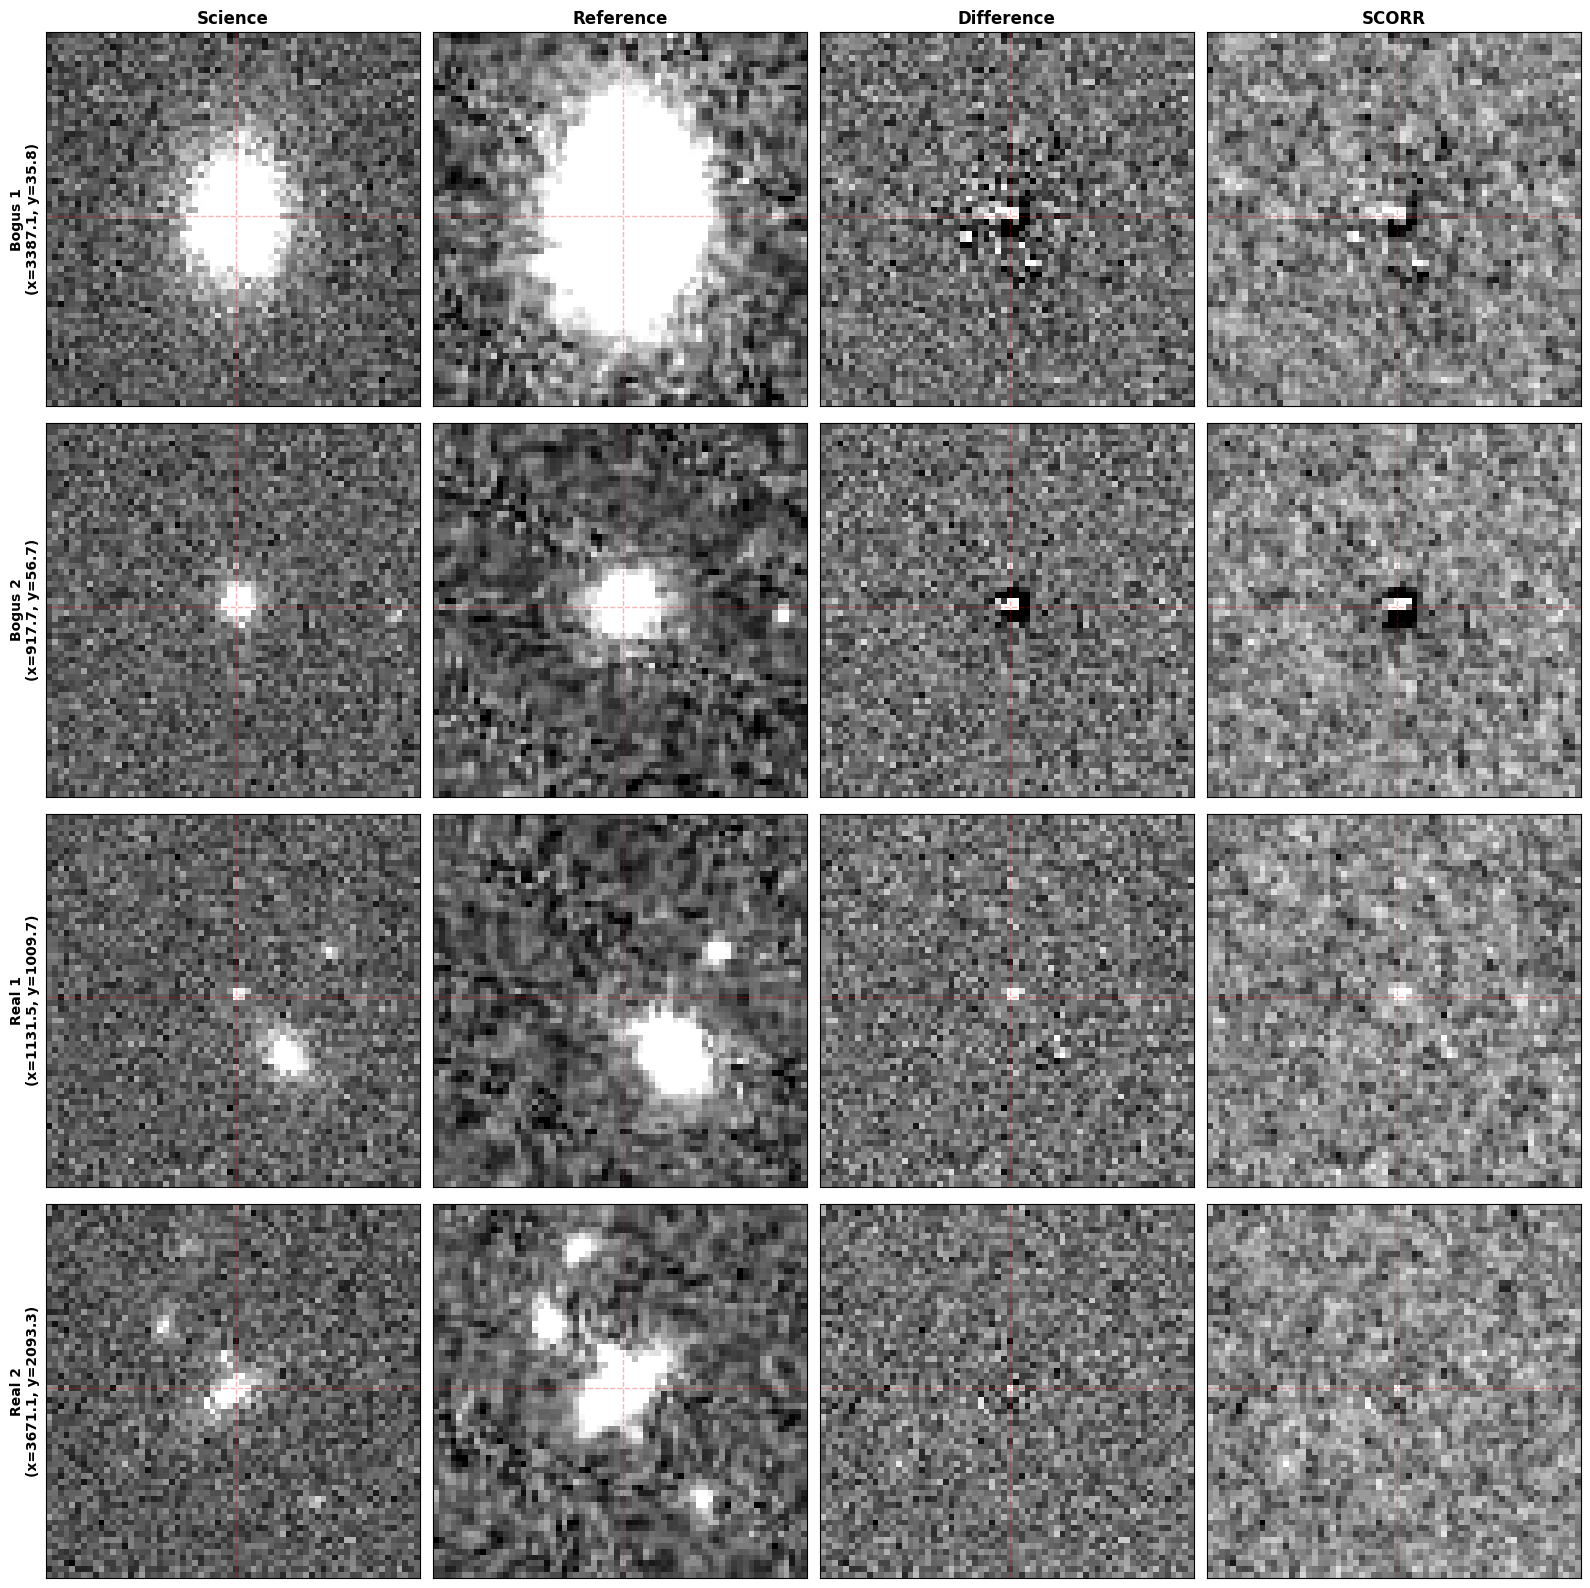


Summary of Examples:

Bogus 1:
  Position: (3387.1, 35.8)
  Flux: 1.42, Mag: -0.38
  Sharpness: 0.745

Bogus 2:
  Position: (917.7, 56.7)
  Flux: 6.67, Mag: -2.06
  Sharpness: 0.913

Real 1:
  Position: (1131.5, 1009.7)
  Flux: 2.39, Mag: -0.95
  Sharpness: 0.793

Real 2:
  Position: (3671.1, 2093.3)
  Flux: 0.02, Mag: 4.06
  Sharpness: 0.520


In [51]:
# Find 2 bogus and 2 real examples that are not at image edges
bogus_examples = []
real_examples = []

for record in cutouts_dataset.records("transient_candidates"):
    x = record['transient_candidates/x']
    y = record['transient_candidates/y']
    label = record['transient_candidates/label']
    
    # Prefer examples not at edges (at least 32 pixels from boundary)
    if x > 32 and y > 32:
        if label == 0 and len(bogus_examples) < 2:
            bogus_examples.append(record)
        elif label == 1 and len(real_examples) < 2:
            real_examples.append(record)
    
    if len(bogus_examples) == 2 and len(real_examples) == 2:
        break

# If we didn't find enough non-edge examples, get any examples
if len(bogus_examples) < 2 or len(real_examples) < 2:
    bogus_examples = []
    real_examples = []
    for record in cutouts_dataset.records("transient_candidates"):
        label = record['transient_candidates/label']
        if label == 0 and len(bogus_examples) < 2:
            bogus_examples.append(record)
        elif label == 1 and len(real_examples) < 2:
            real_examples.append(record)
        if len(bogus_examples) == 2 and len(real_examples) == 2:
            break

# Load cutouts
examples = [
    (bogus_examples[0], 'Bogus 1'),
    (bogus_examples[1], 'Bogus 2'),
    (real_examples[0], 'Real 1'),
    (real_examples[1], 'Real 2')
]

cutout_data = []
for record, title in examples:
    rel_path = record['transient_candidates/cutout_path']
    if isinstance(rel_path, bytes):
        rel_path = rel_path.decode('utf-8')
    cutout_path = Path(cutouts_dataset_dir) / rel_path
    cutout = np.load(cutout_path)
    cutout_data.append((cutout, title, record))

# Visualize all 4 examples with their 4 channels
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
channel_names = ['Science', 'Reference', 'Difference', 'SCORR']

for row, (cutout, title, record) in enumerate(cutout_data):
    for col, channel_name in enumerate(channel_names):
        ax = axes[row, col]
        im = ax.imshow(cutout[:, :, col], cmap='gray', origin='lower')
        
        if col == 0:
            ax.set_ylabel(f"{title}\n(x={record['transient_candidates/x']:.1f}, y={record['transient_candidates/y']:.1f})", 
                         fontsize=10, fontweight='bold')
        
        if row == 0:
            ax.set_title(channel_name, fontsize=12, fontweight='bold')
        
        # Add crosshairs at center
        ax.axhline(y=32, color='r', linestyle='--', alpha=0.3, linewidth=1)
        ax.axvline(x=32, color='r', linestyle='--', alpha=0.3, linewidth=1)
        
        # Remove tick labels for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary of Examples:")
for cutout, title, record in cutout_data:
    print(f"\n{title}:")
    print(f"  Position: ({record['transient_candidates/x']:.1f}, {record['transient_candidates/y']:.1f})")
    print(f"  Flux: {record['transient_candidates/flux']:.2f}, Mag: {record['transient_candidates/mag']:.2f}")
    print(f"  Sharpness: {record['transient_candidates/sharpness']:.3f}")

### Creating a PyTorch Dataset for Cutouts

In [52]:
class CutoutsDataset(Dataset):
    """PyTorch dataset for pre-extracted cutouts."""
    
    def __init__(self, croissant_path):
        self.dataset_dir = Path(croissant_path).parent
        dataset = mlc.Dataset(jsonld=croissant_path)
        self.records = list(dataset.records("transient_candidates"))
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        record = self.records[idx]
        
        # Load pre-extracted cutout
        rel_path = record['transient_candidates/cutout_path']
        if isinstance(rel_path, bytes):
            rel_path = rel_path.decode('utf-8')
        cutout_path = self.dataset_dir / rel_path
        cutout = np.load(cutout_path)
        
        # Convert to tensor (channels first for PyTorch)
        image_tensor = torch.from_numpy(cutout).permute(2, 0, 1).float()
        
        # Tabular features (handle None values by replacing with 0.0)
        features = torch.tensor([
            record['transient_candidates/sharpness'] or 0.0,
            record['transient_candidates/roundness1'] or 0.0,
            record['transient_candidates/roundness2'] or 0.0,
            record['transient_candidates/npix'] or 0.0,
            record['transient_candidates/peak'] or 0.0,
            record['transient_candidates/flux'] or 0.0,
            record['transient_candidates/mag'] or 0.0,
            record['transient_candidates/daofind_mag'] or 0.0
        ], dtype=torch.float32)
        
        label = torch.tensor(record['transient_candidates/label'], dtype=torch.long)
        
        return image_tensor, features, label

# Create dataset instance
cutouts_ds = CutoutsDataset(cutouts_croissant_path)
print(f"Cutouts dataset size: {len(cutouts_ds)}")

# Test loading
img, feats, lbl = cutouts_ds[0]
print(f"Image tensor shape: {img.shape}")
print(f"Features shape: {feats.shape}")
print(f"Label: {lbl.item()}")

  -  [Metadata(roman_croissant_cutouts)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(roman_croissant_cutouts)] Property "https://schema.org/version" is recommended, but does not exist.


Cutouts dataset size: 3195
Image tensor shape: torch.Size([4, 64, 64])
Features shape: torch.Size([8])
Label: 0


## Part 3: Creating DataLoaders for Training

In [53]:
# Create DataLoader for full images dataset
full_loader = DataLoader(
    full_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0  # Set to > 0 for multi-processing
)

# Create DataLoader for cutouts dataset
cutouts_loader = DataLoader(
    cutouts_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

print("DataLoaders created successfully!")
print(f"Full images batches: {len(full_loader)}")
print(f"Cutouts batches: {len(cutouts_loader)}")

DataLoaders created successfully!
Full images batches: 100
Cutouts batches: 100


### Testing a Training Loop

In [54]:
# Test iteration through cutouts dataset (faster for demo)
print("Testing batch loading...\n")

for batch_idx, (images, features, labels) in enumerate(cutouts_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Features shape: {features.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Labels distribution: {labels.sum().item()} real, {(labels == 0).sum().item()} bogus")
    
    if batch_idx >= 2:  # Show first 3 batches
        break

Testing batch loading...

Batch 1:
  Images shape: torch.Size([32, 4, 64, 64])
  Features shape: torch.Size([32, 8])
  Labels shape: torch.Size([32])
  Labels distribution: 0 real, 32 bogus
Batch 2:
  Images shape: torch.Size([32, 4, 64, 64])
  Features shape: torch.Size([32, 8])
  Labels shape: torch.Size([32])
  Labels distribution: 1 real, 31 bogus
Batch 3:
  Images shape: torch.Size([32, 4, 64, 64])
  Features shape: torch.Size([32, 8])
  Labels shape: torch.Size([32])
  Labels distribution: 0 real, 32 bogus


## Part 4: Dataset Statistics and Exploration

In [55]:
# Load all records into a DataFrame for analysis
cutout_records_list = list(cutouts_dataset.records("transient_candidates"))
df = pd.DataFrame(cutout_records_list)

print("Dataset Summary:")
print(f"Total candidates: {len(df)}")
print(f"\nLabel distribution:")
print(df['transient_candidates/label'].value_counts())
print(f"\nClass balance: {df['transient_candidates/label'].mean():.2%} real transients")

Dataset Summary:
Total candidates: 3195

Label distribution:
transient_candidates/label
0    3170
1      25
Name: count, dtype: int64

Class balance: 0.78% real transients


In [56]:
# Feature statistics
feature_cols = ['transient_candidates/sharpness', 'transient_candidates/roundness1', 'transient_candidates/roundness2', 'transient_candidates/npix', 'transient_candidates/peak', 'transient_candidates/flux', 'transient_candidates/mag', 'transient_candidates/daofind_mag']

print("Feature statistics:\n")
print(df[feature_cols].describe())

Feature statistics:

       transient_candidates/sharpness  transient_candidates/roundness1  \
count                     3195.000000                      3195.000000   
mean                         0.791316                         0.008871   
std                          0.144041                         0.459736   
min                          0.230344                        -0.998806   
25%                          0.709259                        -0.327505   
50%                          0.821348                        -0.001507   
75%                          0.898160                         0.357875   
max                          0.999927                         0.997349   

       transient_candidates/roundness2  transient_candidates/npix  \
count                      3195.000000                     3195.0   
mean                         -0.021326                       25.0   
std                           0.439984                        0.0   
min                          -0.9982

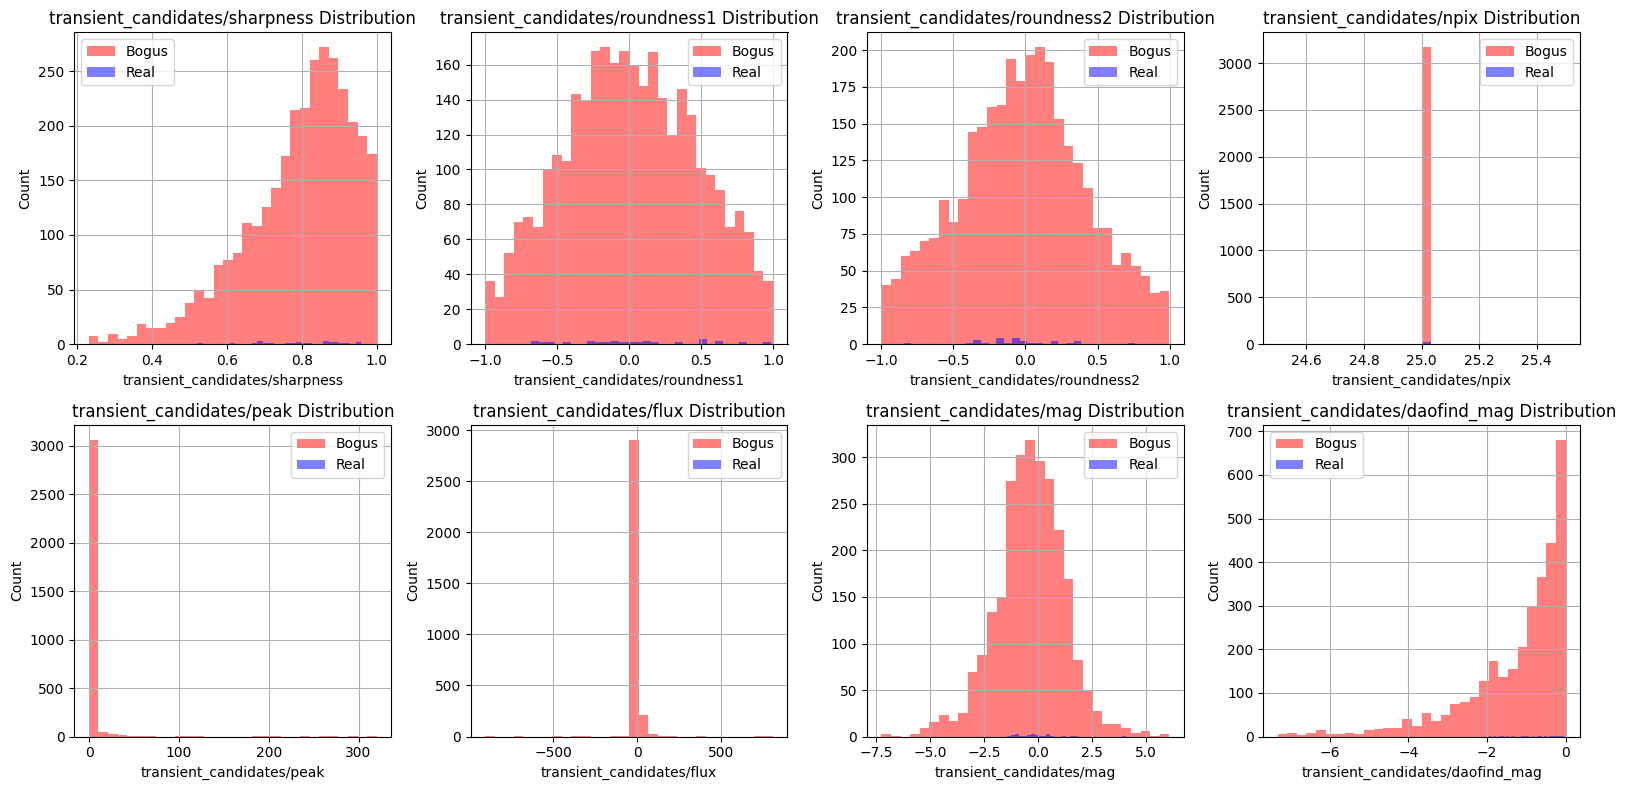

In [57]:
# Visualize feature distributions by class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    df[df['transient_candidates/label'] == 0][col].hist(ax=ax, bins=30, alpha=0.5, label='Bogus', color='red')
    df[df['transient_candidates/label'] == 1][col].hist(ax=ax, bins=30, alpha=0.5, label='Real', color='blue')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. Loading both datasets using Croissant metadata
2. Inspecting image data and metadata fields
3. Visualizing multi-channel astronomical images
4. Creating PyTorch Dataset classes for both formats
5. Setting up DataLoaders for training
6. Analyzing dataset statistics and feature distributions
7. Understanding when to use each dataset variant

Both datasets provide the same features and labels, just in different storage formats optimized for different use cases.